In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, chi2 , f_classif, VarianceThreshold
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [228]:
data = pd.read_csv("sobar-72.csv")
data.drop(labels="ca_cervix",axis=1, inplace=True)

In [229]:
data.columns
df = data.copy()
df.shape

(72, 19)

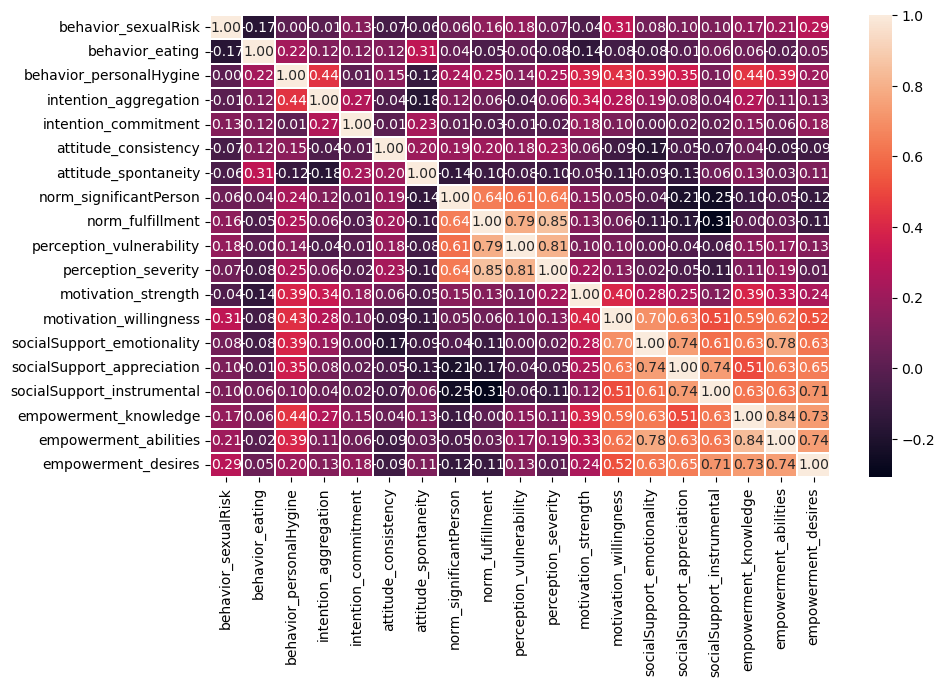

In [230]:
corr = df.corr(method = 'pearson')
plt.figure(figsize=(10,6)) # dpi =500 augmente la taille de l'image 
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.2)
plt.show()

PCA

In [231]:
df = df.drop(labels=["empowerment_knowledge","perception_severity"],axis=1)

scaler = StandardScaler()
X_scaler = scaler.fit_transform(df)


n_components = 2

pca = PCA(n_components=n_components)
X_pca =pca.fit_transform(X_scaler)

In [232]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree.cumsum().round(2)

x_list = range(1, n_components+1)
list(x_list)

scree_cum = scree.cumsum().round(2)
scree_cum

array([27.97, 44.32])

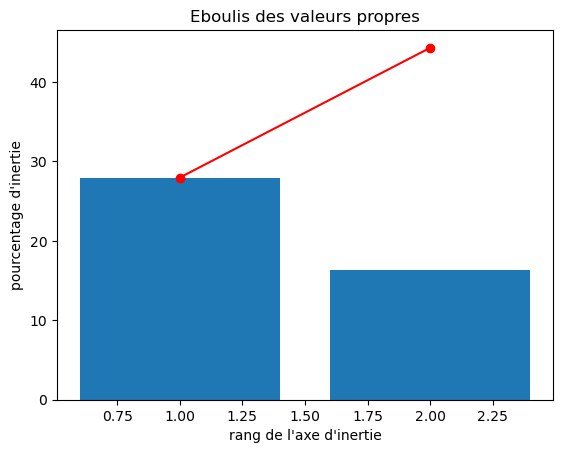

In [233]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [234]:
pcs = pd.DataFrame(pca.components_, columns=df.columns)
pcs.index = [f"F{i}" for i in range(1, n_components + 1)]

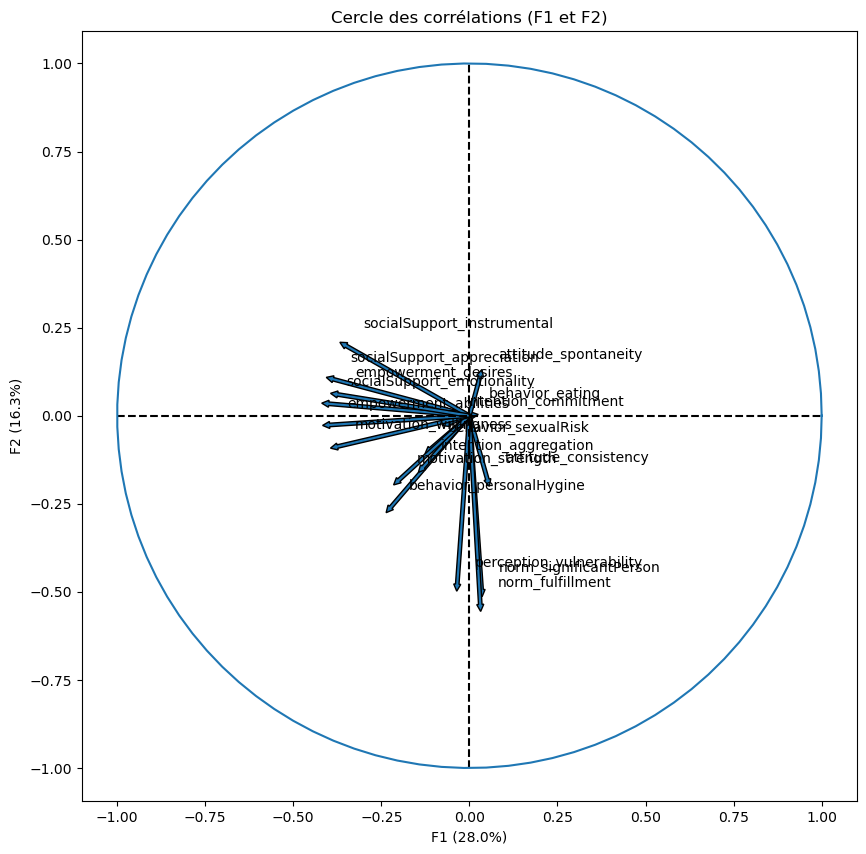

In [235]:
x, y = 0,1
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.02,
             head_length=0.02, 
             width=0.01,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns [i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='black', ls='--')
plt.plot([0, 0], [-1, 1], color='black', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

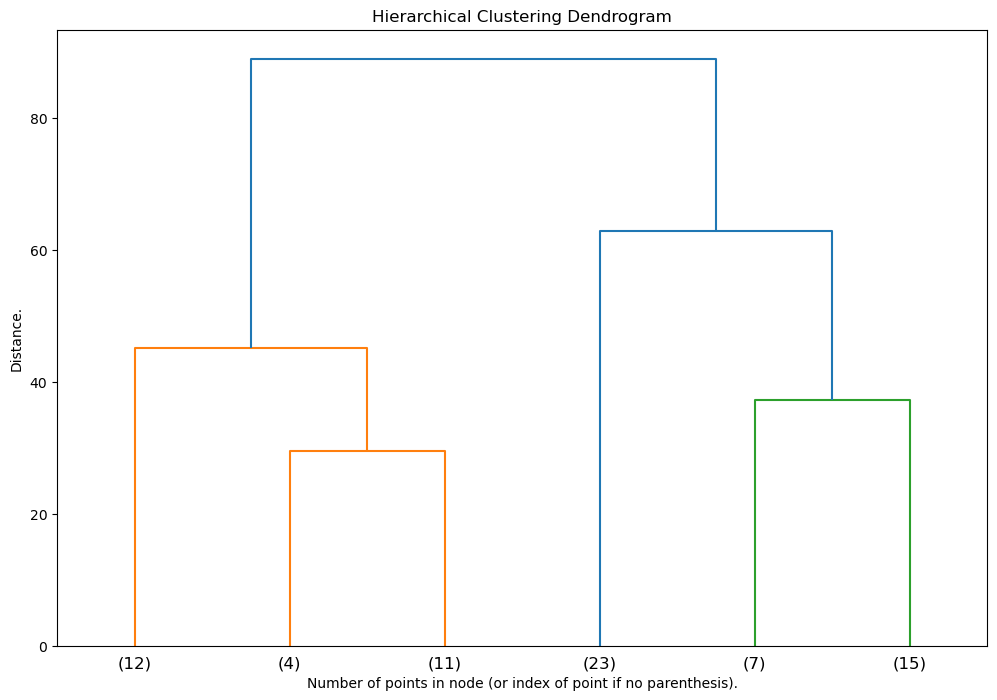

In [236]:
Y = df.values
w = linkage(Y, method="ward")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

dendrogram(w, p=6, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

Kmeans 

In [237]:

# Stocker les valeurs transformées de PCA
X_proj = pca.transform(X_scaler)
X_df = pd.DataFrame(X_proj, columns=[f'F{i+1}' for i in range(n_components)])

In [238]:
X=X_scaler
# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

silhouette = []
# Notre liste de nombres de clusters : 
k_list = range(2, 8)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # On entraine
    kmeans.fit_predict(X_pca)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))

c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans 

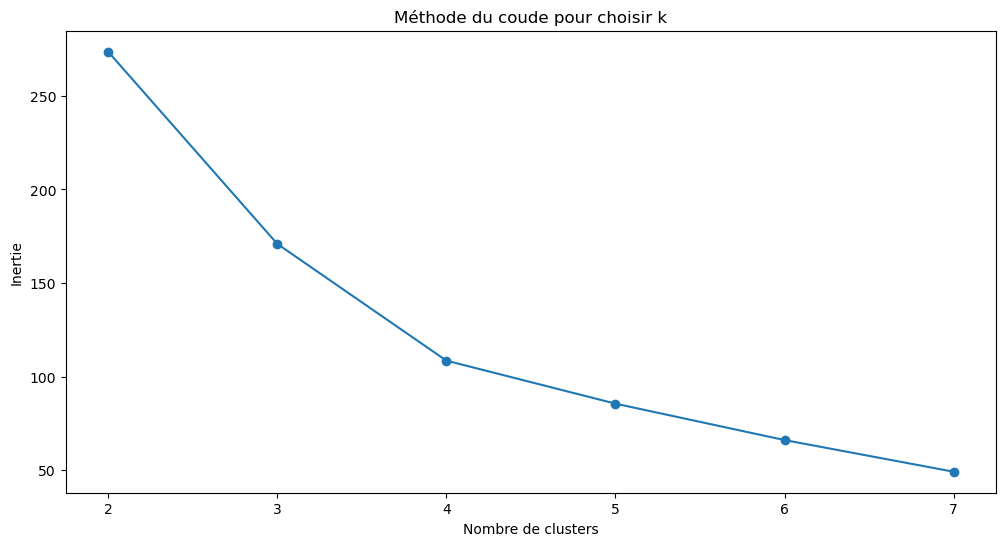

In [239]:
# Affichage de la courbe d'inertie
plt.figure(figsize=(12, 6))
plt.plot(k_list, intertia_list, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour choisir k")
plt.show()

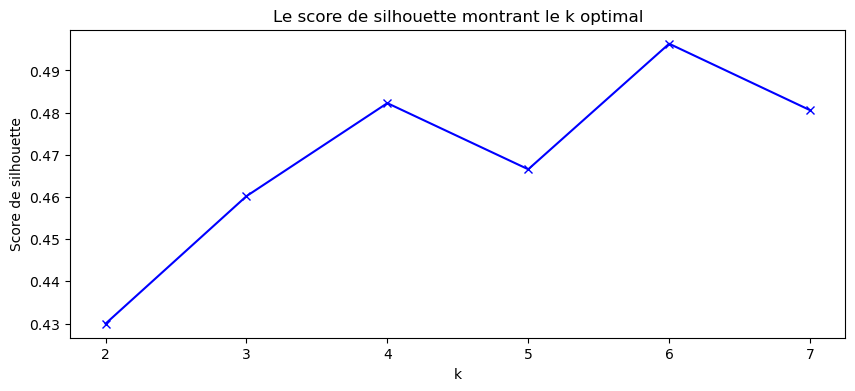

In [240]:

# Graphique du score de silhouette
plt.figure(figsize=(10,4))
plt.plot(k_list, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

In [241]:
kmeans = KMeans(n_clusters=4, random_state=42,n_init=10 )
kmeans.fit_predict(X_pca)
X_df["cluster"] = kmeans.labels_

c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Centroide

In [ ]:
centroids = kmeans.cluster_centers_
centroids_proj = pca.transform(centroids)

In [242]:
dd = {i:j for i,j in enumerate(list("ABCD"))}
labels = [dd[i] for i in kmeans.labels_]
X_df["cluster"] = labels

##### Fonction de visualisation

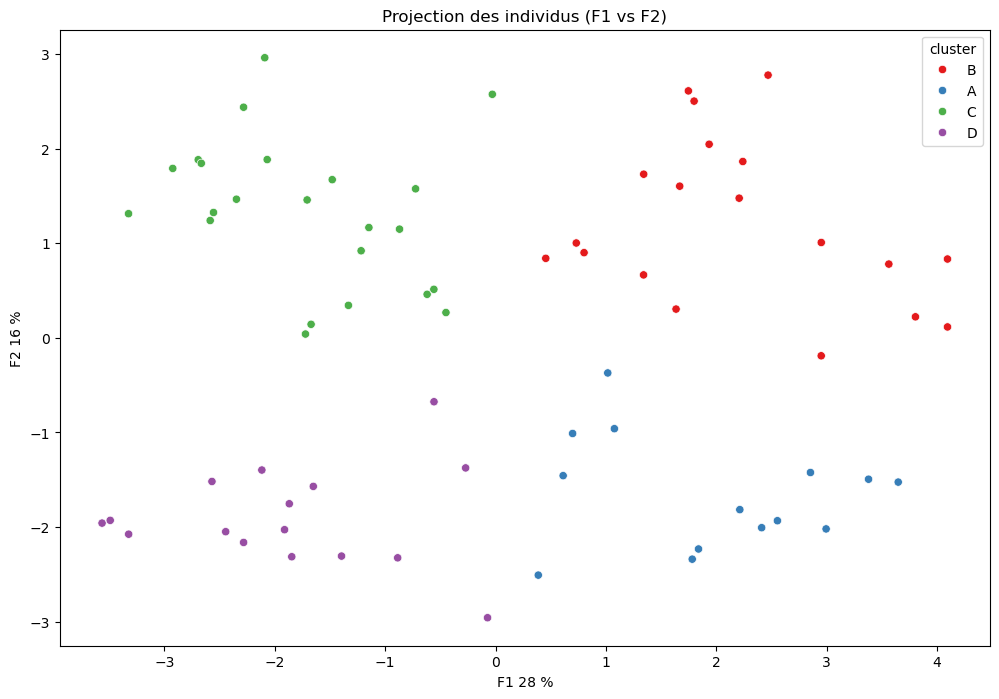

In [243]:
def display_factorial_planes(X_proj, x_y, pca=None, labels=None, clusters=None, alpha=1, figsize=[10,8], marker="o"):
    X = np.array(X_proj)
    x, y = x_y

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    c = None if clusters is None else clusters
    
    sns.scatterplot(x=X[:, x], y=X[:, y], hue=c, palette="Set1", marker=marker, alpha=alpha)

    if pca:
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else:
        v1 = v2 = ''

    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    
    plt.title(f"Projection des individus (F{x+1} vs F{y+1})")
    plt.show()

# Affichage des clusters en projection PCA
display_factorial_planes(X_proj, [0,1], pca, clusters=X_df["cluster"], figsize=(12,8))


In [ ]:
# plt.figure(figsize=(10,6))
# sns.scatterplot(x=X_proj[:, 0],y= X_proj[:, 1], hue=labels, palette="Set1", alpha=0.6)

# plt.scatter(centroids_proj[:, 0], centroids_proj[:, 1], c="black", marker="o", s=200)

# plt.xlabel("F1")
# plt.ylabel("F2")
# plt.legend()

Ajout de la colonne cluster dans le dataset

In [247]:
df["cluster"] = X_df["cluster"]

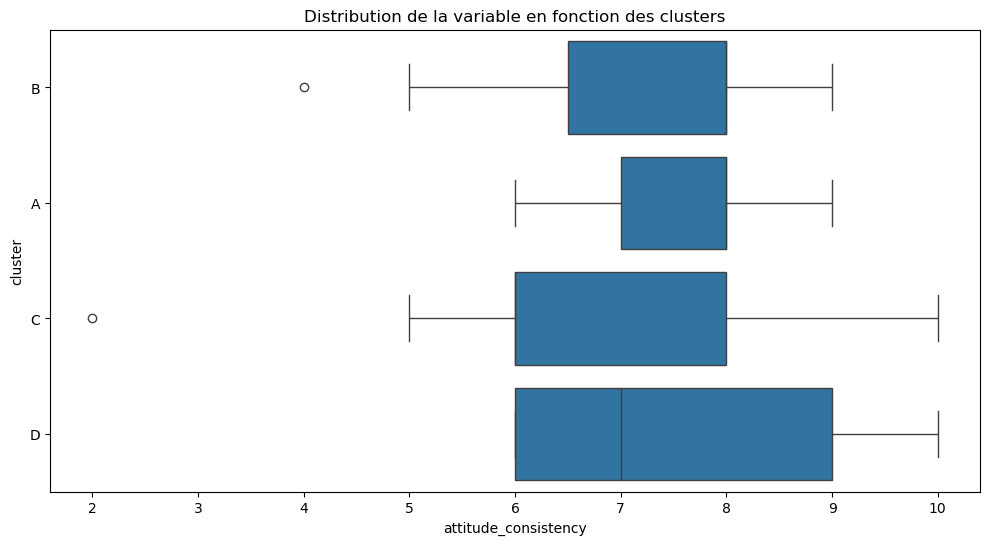

In [248]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["attitude_consistency"], y=df["cluster"], data=df)
plt.title("Distribution de la variable en fonction des clusters")
plt.show()

In [249]:
df.groupby("cluster").mean().round(2)

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_abilities,empowerment_desires
cluster,,,,,,,,,,,,,,,,,
A,9.71,12.36,10.29,8.29,14.00,7.50,8.71,4.71,13.14,11.36,13.71,7.50,3.71,3.29,5.71,6.36,6.79
B,9.05,13.84,9.21,6.84,12.53,7.16,8.84,2.11,5.32,6.11,10.05,5.58,4.79,4.00,8.53,5.47,6.89
C,9.96,12.00,11.35,7.96,13.61,6.70,8.74,1.78,4.61,5.57,13.26,12.04,11.13,8.48,13.43,12.00,13.17
D,9.94,13.06,13.62,8.75,13.38,7.62,8.06,4.88,13.75,13.12,13.94,13.12,11.50,7.94,12.25,12.62,13.19


In [250]:
df.query("cluster=='A'")

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_abilities,empowerment_desires,cluster
1,10,11,11,10,14,7,7,5,5,4,15,13,7,6,5,4,4,A
48,10,15,11,10,15,8,10,1,15,15,15,13,3,2,9,8,11,A
49,6,15,11,10,12,8,10,5,14,13,15,7,5,2,5,9,3,A
52,10,9,12,10,14,9,6,5,11,11,15,11,3,2,6,7,3,A
56,10,10,5,2,15,8,10,5,13,15,15,3,3,2,13,15,15,A
57,10,11,8,10,15,7,8,5,14,13,12,7,4,3,3,4,7,A
58,10,11,9,6,15,6,8,5,14,11,11,7,3,2,3,3,3,A
59,10,13,9,10,15,8,8,5,14,8,11,3,3,2,3,3,3,A
60,10,12,10,10,15,6,8,5,15,11,13,7,3,2,3,3,3,A
62,10,13,11,6,15,8,10,5,15,7,13,7,3,5,3,3,3,A
